In [1]:
import pandas as pd
import matplotlib.pyplot as plt


## Importing Dataset

In [2]:
df = pd.read_csv("data/anomalies.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)


FileNotFoundError: [Errno 2] No such file or directory: 'data/anomalies.csv'

In [ ]:
df

,User,ID,Process,FKL_Process,Rule1,Time1,Anomaly
Datetime,,,,,,,
2022-12-31 20:07:03,S398,64901,Login,16,False,False,False
2022-12-31 20:22:35,S314,30838,Login,13,False,False,False
2022-12-31 20:31:50,S612,44993,Login,15,True,False,True
2022-12-31 20:36:39,S414,69111,Login,8,True,False,True
2022-12-31 20:41:04,S960,52703,Login,10,True,False,True
...,...,...,...,...,...,...,...
2023-11-28 22:41:41,J992,76378,Login,10,True,False,True
2023-11-28 22:43:01,S688,69689,Login,9,True,False,True
2023-11-28 22:45:37,J424,27518,Login,15,True,False,True


## Data Wrangling

In [ ]:
df.index = pd.to_datetime(df.index).round("h")
df.index.name = "Datetime"
df["is_failed"] = df["FKL_Process"].isin([8, 16])  # Define fail codes

# Group by User and Date
summary = df.groupby(["Datetime"]).agg(
    total_logins=("Process", "count"),
    failed_logins=("is_failed", "sum"),
    Rule1=("Rule1", "any"),
    Time1=("Time1", "any"),
    Anomaly=("Anomaly", "any")  # label for training
).reset_index()

summary["fail_ratio"] = summary["failed_logins"] / summary["total_logins"]
summary['Anomaly'] &= (summary['fail_ratio'] > 0.4) & (summary['failed_logins'] > 5) # Added condition if, fail_ratio as well as number of fails are high


In [ ]:
summary

,Datetime,total_logins,failed_logins,Rule1,Time1,Anomaly,fail_ratio
0,2022-12-31 20:00:00,2,1,False,False,False,0.500000
1,2022-12-31 21:00:00,6,1,True,False,False,0.166667
2,2022-12-31 22:00:00,3,0,True,False,False,0.000000
3,2022-12-31 23:00:00,1,0,True,False,False,0.000000
4,2023-01-01 04:00:00,2,0,True,False,False,0.000000
...,...,...,...,...,...,...,...
7396,2023-11-28 20:00:00,2,1,False,False,False,0.500000
7397,2023-11-28 21:00:00,1,0,False,False,False,0.000000
7398,2023-11-28 22:00:00,4,0,True,False,False,0.000000
7399,2023-11-28 23:00:00,6,0,True,False,False,0.000000


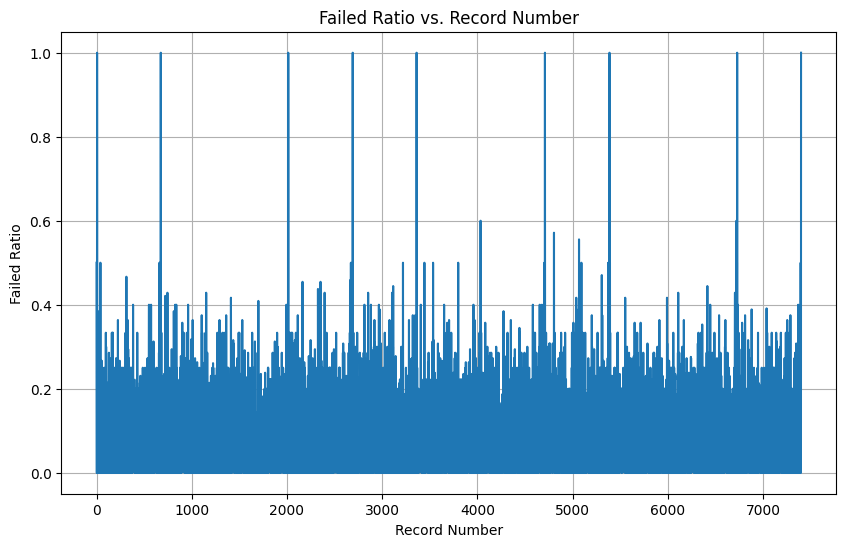

In [ ]:
plt.figure(figsize=(10, 6)) 
plt.plot(summary['fail_ratio'])
plt.xlabel("Record Number")
plt.ylabel("Failed Ratio")
plt.title("Failed Ratio vs. Record Number")
plt.grid(True)
plt.show()

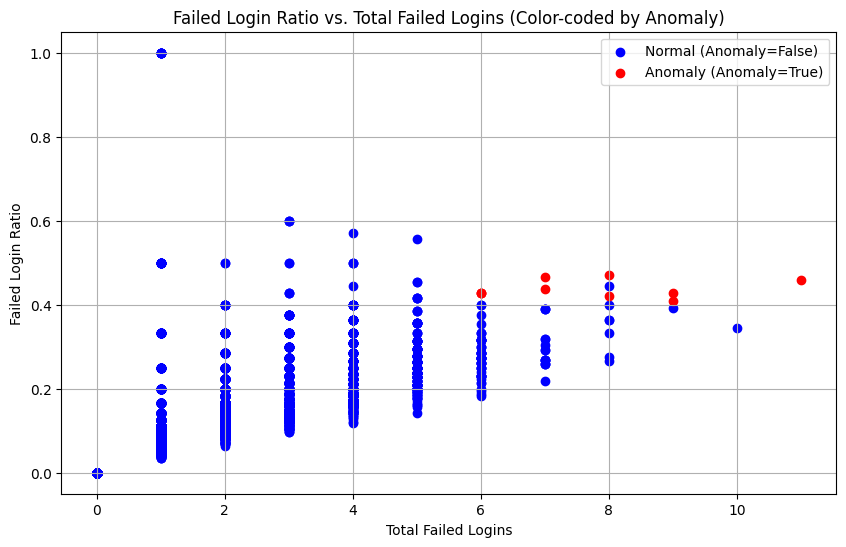

In [ ]:
anomalies = summary[summary['Anomaly'] == True]
normal = summary[summary['Anomaly'] == False]

plt.figure(figsize=(10, 6))
plt.scatter(normal['failed_logins'], normal['fail_ratio'], c='blue', label='Normal (Anomaly=False)')
plt.scatter(anomalies['failed_logins'], anomalies['fail_ratio'], c='red', label='Anomaly (Anomaly=True)')

plt.xlabel("Total Failed Logins")
plt.ylabel("Failed Login Ratio")
plt.title("Failed Login Ratio vs. Total Failed Logins (Color-coded by Anomaly)")
plt.legend()
plt.grid(True)
plt.show()

## Add salt for simulation

In [ ]:
import numpy as np

def syn_anomaly(row, alpha=0.009, beta=0.0025):
    if row['Anomaly']:
        return True
    r = row['fail_ratio']
    n = row['failed_logins']
    return (1 - np.exp(-alpha * r - beta * n))

In [ ]:
summary['Anomaly'] = summary.apply(syn_anomaly, axis=1)
summary['Anomaly'] = summary['Anomaly'] > np.random.rand(len(summary))

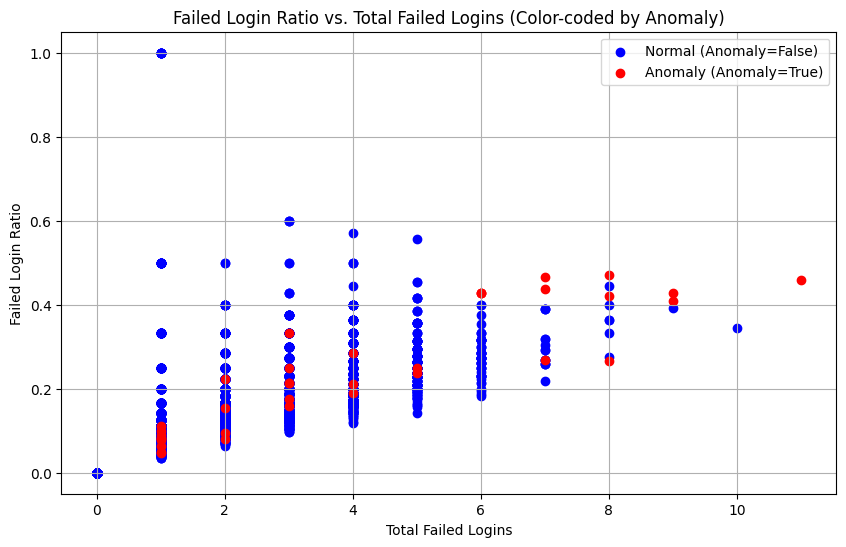

In [ ]:
anomalies = summary[summary['Anomaly'] == True]
normal = summary[summary['Anomaly'] == False]

plt.figure(figsize=(10, 6))
plt.scatter(normal['failed_logins'], normal['fail_ratio'], c='blue', label='Normal (Anomaly=False)')
plt.scatter(anomalies['failed_logins'], anomalies['fail_ratio'], c='red', label='Anomaly (Anomaly=True)')

plt.xlabel("Total Failed Logins")
plt.ylabel("Failed Login Ratio")
plt.title("Failed Login Ratio vs. Total Failed Logins (Color-coded by Anomaly)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
summary

,Datetime,total_logins,failed_logins,Rule1,Time1,Anomaly,fail_ratio
0,2022-12-31 20:00:00,2,1,False,False,False,0.500000
1,2022-12-31 21:00:00,6,1,True,False,False,0.166667
2,2022-12-31 22:00:00,3,0,True,False,False,0.000000
3,2022-12-31 23:00:00,1,0,True,False,False,0.000000
4,2023-01-01 04:00:00,2,0,True,False,False,0.000000
...,...,...,...,...,...,...,...
7396,2023-11-28 20:00:00,2,1,False,False,False,0.500000
7397,2023-11-28 21:00:00,1,0,False,False,False,0.000000
7398,2023-11-28 22:00:00,4,0,True,False,False,0.000000
7399,2023-11-28 23:00:00,6,0,True,False,False,0.000000


## Import libraries for Machine Learning

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

## Feature Extraction and Engineering

In [ ]:
summary['hour'] = summary['Datetime'].dt.hour
summary['dayofweek'] = summary['Datetime'].dt.dayofweek

summary['Rule1'] = summary['Rule1'].astype(int)
summary['Time1'] = summary['Time1'].astype(int)
summary['Anomaly'] = summary['Anomaly'].astype(int)

In [ ]:
features = ['total_logins', 'failed_logins', 'fail_ratio', 'Rule1', 'Time1', 'hour', 'dayofweek']
X = summary[features]
y = summary['Anomaly']

## Test-Train Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## Feature Scaling

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## SMOTE

In [ ]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

## Training XGBoost

In [ ]:
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train_res, y_train_res)

z:\SE Project\3SO\anomaly-detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:47:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

## Training SVM Polynomial Kernel

In [ ]:
svm_poly = SVC(kernel='poly', degree=2, C=1.0, gamma='scale', probability=True, random_state=42)
svm_poly.fit(X_train_res, y_train_res)


SVC(degree=2, kernel='poly', probability=True, random_state=42)

## Prediction

In [ ]:
y_pred_xgb = xgb.predict(X_test_scaled)
y_pred_svm = svm_poly.predict(X_test_scaled)

## Metric XGB

In [ ]:
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb, digits=4))

[[1468    6]
 [   6    1]]
              precision    recall  f1-score   support

           0     0.9959    0.9959    0.9959      1474
           1     0.1429    0.1429    0.1429         7

    accuracy                         0.9919      1481
   macro avg     0.5694    0.5694    0.5694      1481
weighted avg     0.9919    0.9919    0.9919      1481



## Metric SVM

In [ ]:
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, digits=4))

[[1192  282]
 [   5    2]]
              precision    recall  f1-score   support

           0     0.9958    0.8087    0.8925      1474
           1     0.0070    0.2857    0.0137         7

    accuracy                         0.8062      1481
   macro avg     0.5014    0.5472    0.4531      1481
weighted avg     0.9911    0.8062    0.8884      1481



## Metric Simple Ensemble

In [ ]:
y_pred_ens = np.logical_or(y_pred_xgb, y_pred_svm).astype(int)

print(confusion_matrix(y_test, y_pred_ens))
print(classification_report(y_test, y_pred_ens, digits=4))

[[1189  285]
 [   5    2]]
              precision    recall  f1-score   support

           0     0.9958    0.8066    0.8913      1474
           1     0.0070    0.2857    0.0136         7

    accuracy                         0.8042      1481
   macro avg     0.5014    0.5462    0.4525      1481
weighted avg     0.9911    0.8042    0.8872      1481



In [ ]:
from sklearn.ensemble import VotingClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression


## Metric VotingClassifier

In [ ]:
ensemble = VotingClassifier(estimators=[
    ('svm', svm_poly), 
    ('xgb', xgb)
], voting='soft')  # 'hard' or 'soft'

ensemble.fit(X_train_res, y_train_res)
y_pred_ens = ensemble.predict(X_test)

print(confusion_matrix(y_test, y_pred_ens))
print(classification_report(y_test, y_pred_ens, digits=4))

z:\SE Project\3SO\anomaly-detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:48:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
z:\SE Project\3SO\anomaly-detection\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


[[1471    3]
 [   7    0]]
              precision    recall  f1-score   support

           0     0.9953    0.9980    0.9966      1474
           1     0.0000    0.0000    0.0000         7

    accuracy                         0.9932      1481
   macro avg     0.4976    0.4990    0.4983      1481
weighted avg     0.9906    0.9932    0.9919      1481



## Metric GradientBoostingClassifier

In [ ]:
meta_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Build stacking ensemble
stacked_model = StackingClassifier(
    estimators=[
        ('svm', svm_poly),
        ('xgb', xgb)
    ],
    final_estimator=meta_clf,
    cv=5,            # Cross-validation to avoid overfitting
    stack_method='predict_proba'  # Uses probabilities from base models
)

stacked_model.fit(X_train_res, y_train_res)

y_pred = stacked_model.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

z:\SE Project\3SO\anomaly-detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:48:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
z:\SE Project\3SO\anomaly-detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:48:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[[1471    3]
 [   6    1]]
              precision    recall  f1-score   support

           0     0.9959    0.9980    0.9970      1474
           1     0.2500    0.1429    0.1818         7

    accuracy                         0.9939      1481
   macro avg     0.6230    0.5704    0.5894      1481
weighted avg     0.9924    0.9939    0.9931      1481



## Since our objective is to maximize the detection of true anomalies. SVM with polynomial model is chosen as the best model as it has the highest recall.

Saving the model

In [ ]:
import joblib

joblib.dump(svm_poly, 'utils/ML/svm_model.pkl')
joblib.dump(scaler, 'utils/ML/scaler.pkl')


['utils/ML/scaler.pkl']